<a href="https://colab.research.google.com/github/falseywinchnet/AI_STUFF/blob/main/Lorenz_RCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch.optim.optimizer import Optimizer
import torch
import math

class RCO_Batching(Optimizer):
    """
    Runge-Kutta-Chebyshev Optimizer (RCO) with batching support and scheduler compatibility
    """
    def __init__(self, params, loss_function=None, lr=1e-3, eps=1e-8,
                 accumulation_steps=1, max_batch_size=None):
        defaults = dict(lr=lr, eps=eps)
        super(RCO_Batching, self).__init__(params, defaults)

        self.accumulation_steps = accumulation_steps
        self.max_batch_size = max_batch_size
        self.loss_function = loss_function or torch.nn.CrossEntropyLoss()

        # Initialize step counter for scheduler compatibility
        self.state['step'] = 0

        # Pre-compute tensor constants on cuda if available
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.pi_tensor = torch.tensor(math.pi, device=device)

        # Chebyshev weights (convert to tensors)
        sqrt_5 = torch.sqrt(torch.tensor(5.0, device=device))
        self.w1 = self.w2 = (18 + 5*sqrt_5)/72
        self.w3 = self.w4 = (18 - 5*sqrt_5)/72

    def compute_loss(self, x, y):
        """Compute loss for a batch of data"""
        outputs = self.model(x)
        return self.loss_function(outputs, y)

    def _split_batch(self, x, y):
        """Split large batches into smaller ones if needed"""
        if self.max_batch_size is None or x.size(0) <= self.max_batch_size:
            return [(x, y)]

        num_splits = (x.size(0) + self.max_batch_size - 1) // self.max_batch_size
        x_splits = torch.split(x, self.max_batch_size)
        y_splits = torch.split(y, self.max_batch_size)
        return list(zip(x_splits, y_splits))

    def step(self, closure=None):
        """
        Performs a single optimization step.

        Args:
            closure (callable): A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                effective_lr = group['lr'] / self.accumulation_steps

                # Store original params
                orig_param = p.data.clone()

                # Initial k1
                k1 = p.grad.clone()

                # RK4 steps
                # k2 position
                p.data.add_(k1, alpha=-effective_lr/2)
                if closure is not None:
                    with torch.enable_grad():
                        closure()
                k2_rk4 = p.grad.clone()
                p.data.copy_(orig_param)

                # k3 position
                p.data.add_(k2_rk4, alpha=-effective_lr/3)
                if closure is not None:
                    with torch.enable_grad():
                        closure()
                k3_rk4 = p.grad.clone()
                p.data.copy_(orig_param)

                # k4 position
                p.data.add_(k3_rk4, alpha=-effective_lr)
                if closure is not None:
                    with torch.enable_grad():
                        closure()
                k4_rk4 = p.grad.clone()

                # Chebyshev steps
                # Compute nodes
                c1 = effective_lr * (1 + torch.cos(3*self.pi_tensor/8))/2
                c2 = effective_lr * (1 + torch.cos(self.pi_tensor/8))/2
                c3 = effective_lr * (1 - torch.cos(self.pi_tensor/8))/2

                # k2 Cheb
                p.data.copy_(orig_param)
                p.data.add_(k1, alpha=-c1)
                if closure is not None:
                    with torch.enable_grad():
                        closure()
                k2_cheb = p.grad.clone()

                # k3 Cheb
                p.data.copy_(orig_param)
                p.data.add_(k2_cheb, alpha=-c2)
                if closure is not None:
                    with torch.enable_grad():
                        closure()
                k3_cheb = p.grad.clone()

                # k4 Cheb
                p.data.copy_(orig_param)
                p.data.add_(k3_cheb, alpha=-c3)
                if closure is not None:
                    with torch.enable_grad():
                        closure()
                k4_cheb = p.grad.clone()

                # Combine RK4 result
                rk4_update = (k1 + 2*k2_rk4 + 2*k3_rk4 + k4_rk4)/6

                # Combine Cheb result
                cheb_update = (self.w1*k1 + self.w2*k2_cheb + self.w3*k3_cheb + self.w4*k4_cheb)

                # Average the updates and apply
                update = (rk4_update + cheb_update)/2
                p.data = orig_param - effective_lr * update

        return loss

    def get_lr(self):
        """Returns current learning rate for scheduler compatibility"""
        return [group['lr'] for group in self.param_groups]


In [13]:
import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# First, let's create our ground truth data generator
class LorenzSystem:
    def __init__(self, sigma=10.0, rho=28.0, beta=8/3):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def derivatives(self, state, t):
        x, y, z = state
        dx = self.sigma * (y - x)
        dy = x * (self.rho - z) - y
        dz = x * y - self.beta * z
        return [dx, dy, dz]

    def generate_trajectory(self, initial_state, t_span, n_points=1000):
        t = np.linspace(t_span[0], t_span[1], n_points)
        trajectory = odeint(self.derivatives, initial_state, t)
        return t, trajectory

# Neural network to predict Lorenz dynamics
class LorenzPredictor(nn.Module):
    def __init__(self, hidden_size=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 3)
        )

    def forward(self, x):
        return self.net(x)

# Generate training data
def generate_training_data(n_trajectories=100, n_points=1000, t_span=(0, 10)):
    lorenz = LorenzSystem()
    all_trajectories = []

    for _ in range(n_trajectories):
        # Random initial conditions
        initial_state = np.random.randn(3) * 0.1
        _, trajectory = lorenz.generate_trajectory(initial_state, t_span, n_points)
        all_trajectories.append(trajectory)

    return np.vstack(all_trajectories)

# Training setup
def prepare_training_data(trajectories, sequence_length=10):
    X, y = [], []
    for i in range(len(trajectories) - sequence_length):
        X.append(trajectories[i])
        y.append(trajectories[i + 1])  # Predict next state
    return torch.FloatTensor(X), torch.FloatTensor(y)

# Training function
# Modify training function to add gradient clipping
def train_model(model, optimizer, train_X, train_y, n_epochs=1, batch_size=128):
    criterion = nn.MSELoss()
    batch_losses = []  # Changed from losses to batch_losses

    for epoch in range(n_epochs):
        for i in range(0, len(train_X), batch_size):
            batch_X = train_X[i:i+batch_size].cuda()
            batch_y = train_y[i:i+batch_size].cuda()

            def closure():
                optimizer.zero_grad()
                pred = model(batch_X)
                loss = criterion(pred, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                return loss

            loss = optimizer.step(closure)
            batch_losses.append(loss.item())  # Record each batch's loss

            if i % (batch_size * 10) == 0:  # Print every 10 batches
                print(f'Batch {i//batch_size}, Loss: {loss.item():.6f}')

    return batch_losses  # Return all batch losses



# Main experiment
def run_experiment():
    # Generate data
    trajectories = generate_training_data()
    train_X, train_y = prepare_training_data(trajectories)

    # Models and optimizers
    model_rco = LorenzPredictor().cuda()
    model_adam = LorenzPredictor().cuda()

    optimizer_rco = RCO_Batching(model_rco.parameters(), lr=0.5)
    optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=1e-3)

    # Train both models
    losses_rco = train_model(model_rco, optimizer_rco, train_X, train_y)
    losses_adam = train_model(model_adam, optimizer_adam, train_X, train_y)

    return losses_rco, losses_adam


def plot_results(losses_rco, losses_adam):
    plt.figure(figsize=(10, 6))
    plt.plot(losses_rco, label='RCO')
    plt.plot(losses_adam, label='Adam')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Single Epoch Loss Trajectory: RCO vs Adam')
    plt.legend()
    plt.grid(True)
    plt.show()

Batch 0, Loss: 255.847168
Batch 10, Loss: 0.616069
Batch 20, Loss: 1.468115
Batch 30, Loss: 0.639687
Batch 40, Loss: 1.407393
Batch 50, Loss: 1.220466
Batch 60, Loss: 0.188254
Batch 70, Loss: 10.248491
Batch 80, Loss: 0.313000
Batch 90, Loss: 0.220721
Batch 100, Loss: 0.148279
Batch 110, Loss: 0.802115
Batch 120, Loss: 0.110046
Batch 130, Loss: 0.112098
Batch 140, Loss: 3.597478
Batch 150, Loss: 0.030529
Batch 160, Loss: 0.156250
Batch 170, Loss: 0.138491
Batch 180, Loss: 1.228761
Batch 190, Loss: 0.064801
Batch 200, Loss: 0.474480
Batch 210, Loss: 2.890592
Batch 220, Loss: 0.117511
Batch 230, Loss: 0.521389
Batch 240, Loss: 0.075521
Batch 250, Loss: 1.127535
Batch 260, Loss: 0.021134
Batch 270, Loss: 0.639990
Batch 280, Loss: 0.055443
Batch 290, Loss: 0.194252
Batch 300, Loss: 0.237946
Batch 310, Loss: 0.058306
Batch 320, Loss: 3.682064
Batch 330, Loss: 0.052751
Batch 340, Loss: 0.210065
Batch 350, Loss: 0.045804
Batch 360, Loss: 0.038856
Batch 370, Loss: 0.400031
Batch 380, Loss: 0.3

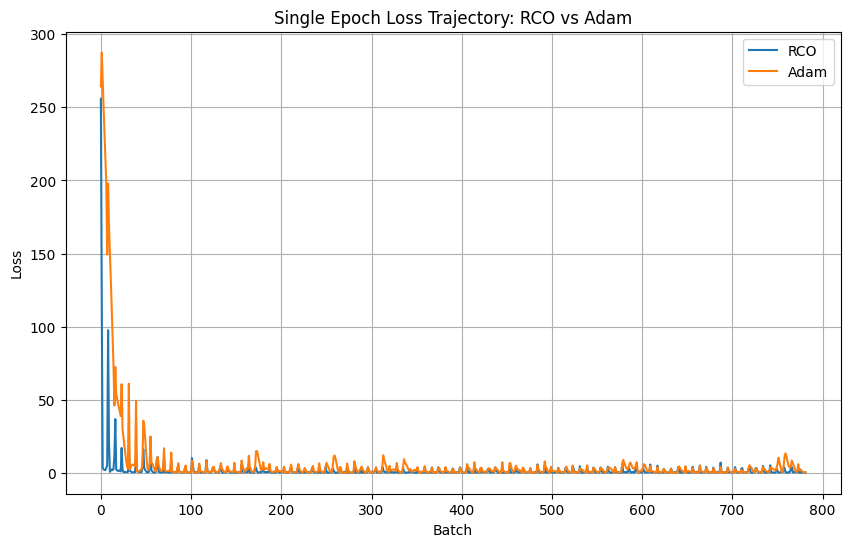

In [14]:
losses_rco, losses_adam = run_experiment()
plot_results(losses_rco, losses_adam)